## Семинар 2 "Распознавание рукописных цифр"

ФИО: Шадрин Сергей Сергеевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [42]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [100]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [10]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

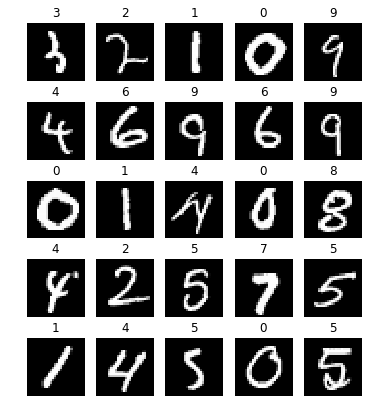

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [3]:
def train(network, epochs, learning_rate, plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [11]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.313/0.308	Accuracy: 0.918/0.919

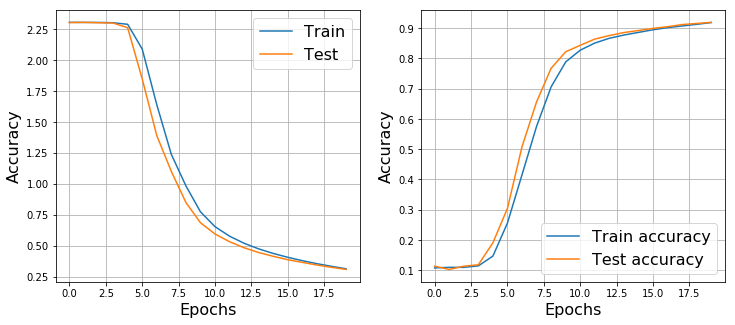

In [12]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [4]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = (self.X >= 0).astype(float)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [5]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [8]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=False, verbose=False)

In [9]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=False, verbose=False)

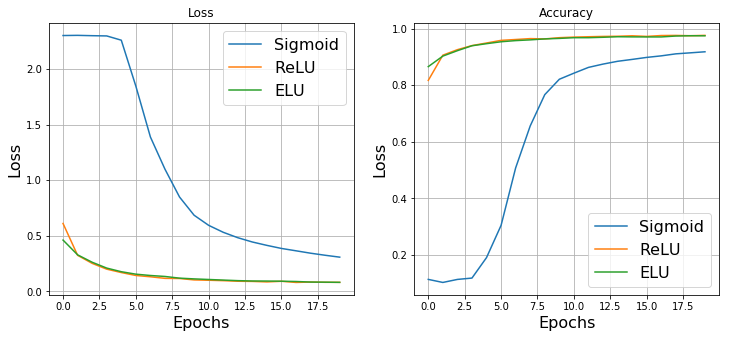

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

> Сравните скорости сходимости и качество классификации с различными функциями активации.

С ReLU и ELU скорость сходимости и качество лучше.

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [14]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

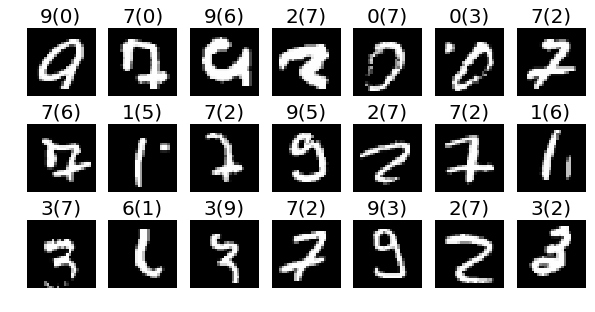

In [15]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### HW1 (1 балл): Реализовать Tanh

In [6]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.tanh(X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (1 / np.cosh(X)) ** 2
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [17]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.030/0.079	Accuracy: 0.994/0.976

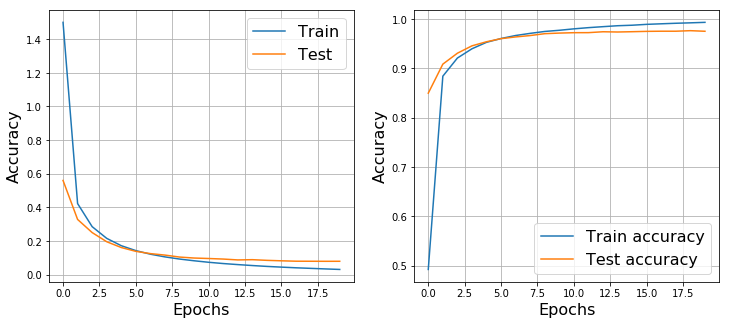

In [18]:
tr_h, ts_h, tr_ac_h, ts_ac_h = train(network, 20, 0.01)

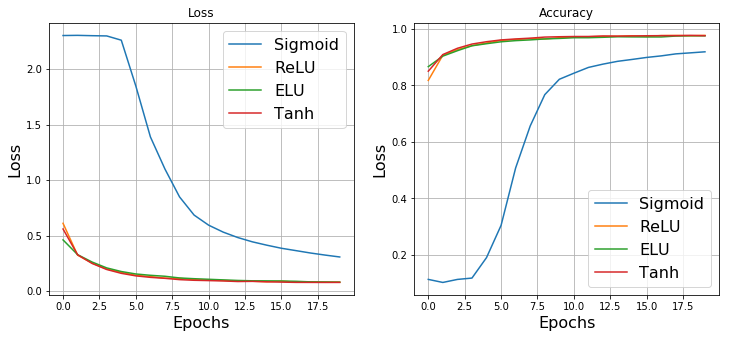

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_h, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_h, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Чтобы лучше было видно, рассмотрим только ReLU, ELU, Tanh.

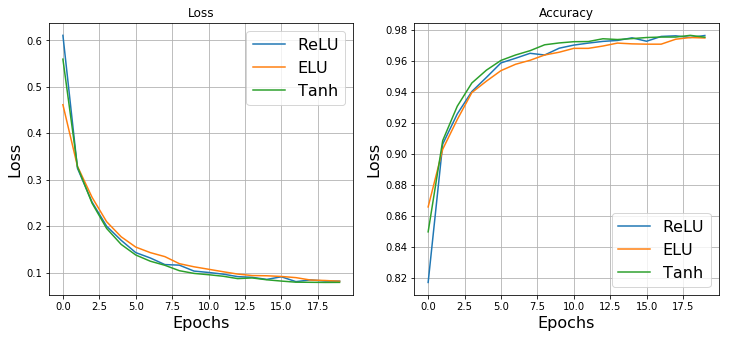

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_h, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_h, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

В данной задаче tanh дает результат лучше.

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [7]:
from skimage.transform import rotate
from skimage.util import random_noise

In [19]:
def random_rotate(img):
    return rotate(img, 30 * np.random.random_sample() - 15)

def random_shift(img):
    return np.roll(img, int(16 * np.random.random_sample() - 8))

Как работают преобразования на одной картинке

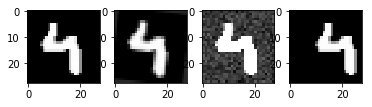

In [21]:
test_img = X[0].reshape(28, 28).astype(np.float)

plt.figure(figsize=(6, 7))

plt.subplot(1, 4, 1)
plt.imshow(test_img, cmap=plt.cm.Greys_r)

plt.subplot(1, 4, 2)
plt.imshow(random_rotate(test_img), cmap=plt.cm.Greys_r)

plt.subplot(1, 4, 3)
plt.imshow(random_noise(test_img), cmap=plt.cm.Greys_r)

plt.subplot(1, 4, 4)
plt.imshow(random_shift(test_img), cmap=plt.cm.Greys_r)

In [187]:
def transform_remove_dim(img_lab):
    return img_lab[0]

def transform_rotate(img_lab):
    return torch.from_numpy(random_rotate(img_lab.numpy().reshape(28, 28).astype(np.float)))

def transform_shift(img_lab):
    return torch.from_numpy(random_shift(img_lab.numpy().reshape(28, 28).astype(np.float)))

def transform_noise(img_lab):
    return torch.from_numpy(random_noise(img_lab.numpy().reshape(28, 28).astype(np.float)))

def transform_add_dim(img_lab):
    return img_lab.view(1, 28, 28).float()

In [188]:
base_transforms = [transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    transform_remove_dim]

composed_r = transforms.Compose(base_transforms + [transform_rotate,
                                                  transform_add_dim])

composed_s = transforms.Compose(base_transforms + [transform_shift,
                                                  transform_add_dim])

composed_n = transforms.Compose(base_transforms + [transform_noise,
                                                  transform_add_dim])

composed_rs = transforms.Compose(base_transforms + [transform_rotate,
                                                    transform_shift,
                                                   transform_add_dim])

composed_rn = transforms.Compose(base_transforms + [transform_rotate,
                                                    transform_noise,
                                                   transform_add_dim])

composed_sn = transforms.Compose(base_transforms + [transform_shift,
                                                    transform_noise,
                                                   transform_add_dim])

composed_rsn = transforms.Compose(base_transforms + [transform_rotate,
                                                     transform_shift,
                                                     transform_noise,
                                                    transform_add_dim])

In [189]:
zipped_transforms = zip([composed_r, None, composed_s, composed_n,
                         composed_rs, composed_rn, composed_sn,
                         composed_rsn], ['r', 'none', 's', 'n', 'rs', 'rn', 'sn', 'rsn'])

In [190]:
from torch.utils.data import ConcatDataset

In [171]:
res_comp = []
len(train_dataset)

60000

In [ ]:
for composed_transform, label in zipped_transforms:
    print("Started: {}".format(label))
    if composed_transform is not None:
        augm_dataset = MNIST('.', train=True, download=True, transform=composed_transform)
        assert(len(train_dataset) == 60000)
        train_loader = DataLoader(ConcatDataset([train_dataset, augm_dataset]), 
                               batch_size=32, shuffle=True)
        pass
    
    network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
    loss = NLLLoss()
    
    tr_h, ts_h, tr_ac_h, ts_ac_h = train(network, 20, 0.01, plot=False, verbose=False)
    res_comp.append([tr_h, ts_h, tr_ac_h, ts_ac_h, label])
    print("Completed: {}".format(label))

Started: r


(запуска не видно, потому что юпитер работал при выключенной вкладке)

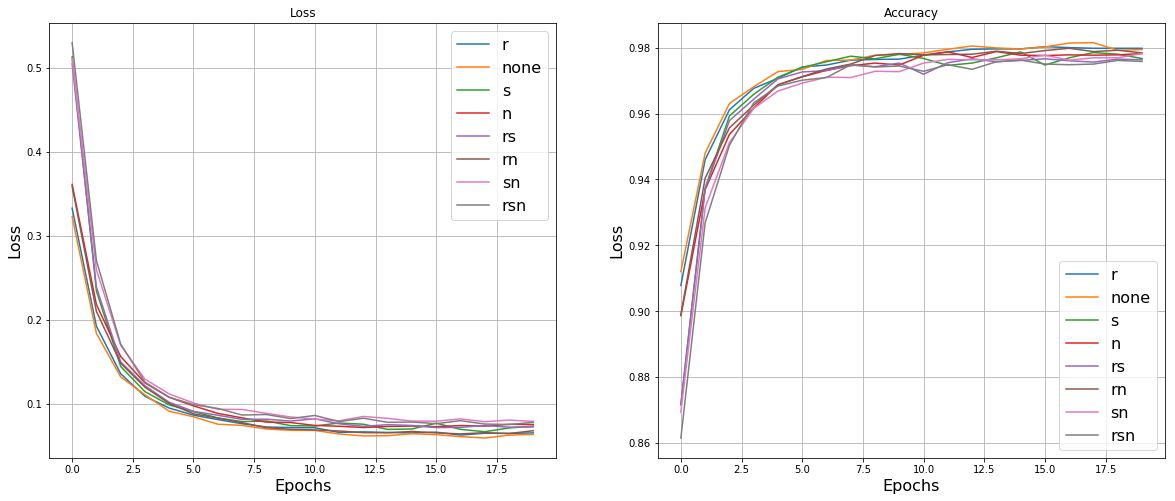

In [179]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('Loss')

for slc in res_comp:
    plt.plot(slc[1], label=slc[4])
    
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)

plt.title('Accuracy')

for slc in res_comp:
    plt.plot(slc[3], label=slc[4])

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)

plt.grid()
plt.show()

r – rotate, s – shift, n – noise

Как мы видим, аугментация вместе с функцией активации tanh особых улучшений не дала.

Попробуем тоже самое с ReLU.

In [191]:
res_comp2 = []

In [192]:
for composed_transform, label in zipped_transforms:
    print("Started: {}".format(label))
    if composed_transform is not None:
        augm_dataset = MNIST('.', train=True, download=True, transform=composed_transform)
        assert(len(train_dataset) == 60000)
        train_loader = DataLoader(ConcatDataset([train_dataset, augm_dataset]), 
                               batch_size=32, shuffle=True)
        pass
    
    network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
    loss = NLLLoss()
    
    tr_h, ts_h, tr_ac_h, ts_ac_h = train(network, 20, 0.01, plot=False, verbose=False)
    res_comp2.append([tr_h, ts_h, tr_ac_h, ts_ac_h, label])
    print("Completed: {}".format(label))

Completed: rsn


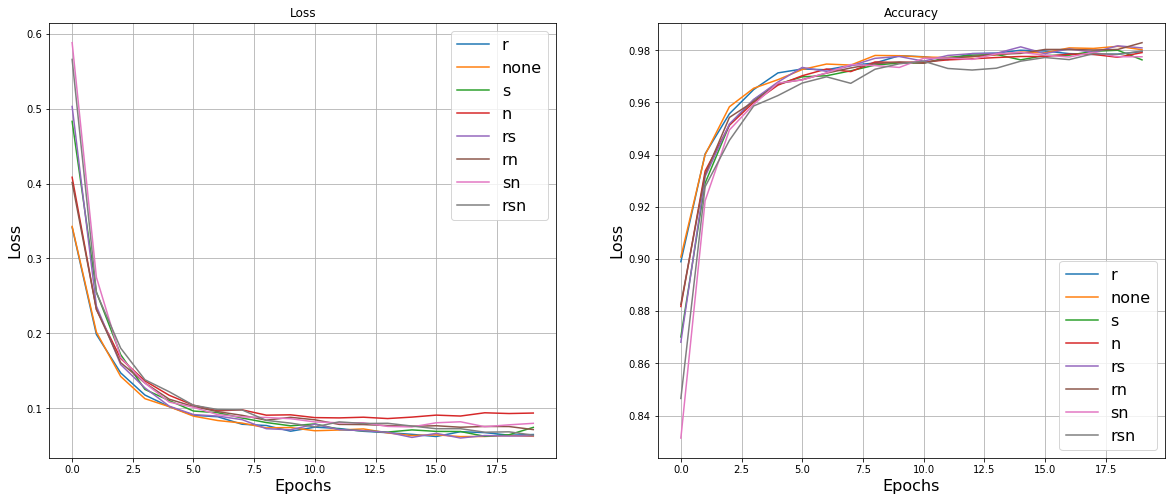

In [193]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('Loss')

for slc in res_comp2:
    plt.plot(slc[1], label=slc[4])
    
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)

plt.title('Accuracy')

for slc in res_comp2:
    plt.plot(slc[3], label=slc[4])

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)

plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Про выбор нелинейности: в данном случае лучший результат дал tanh. Про tanh в интернете написано, что она такая же как логистическая сигмоида, но лучше. Поэтому имеет смысл всегда использовать tanh, а не sigmoid.
ReLU чуть лучше ELU. ReLU наиболее исользуемая функция активации, но её проблема в том, что она обрезает до нуля все отрицательные входы.
ELU решает эту проблему, но на практике из ReLU и ELU лучше выбирать экспериментально.

Предобработка данных на MNIST датасете никаких улучшений в скорости сходимости и итоговом качестве не дала.